In [71]:
import importlib
import os
from pathlib import Path

import cv2
from ultralytics import YOLO
from IPython.display import Image

from src import utils

try:
    importlib.reload(utils)  # reload module
except NameError:
    pass

# !yolo checks

# Display Some Images

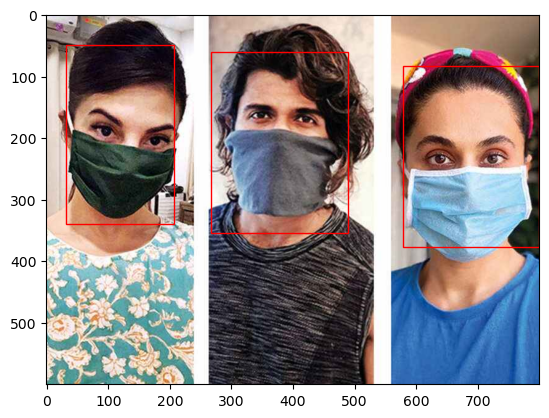

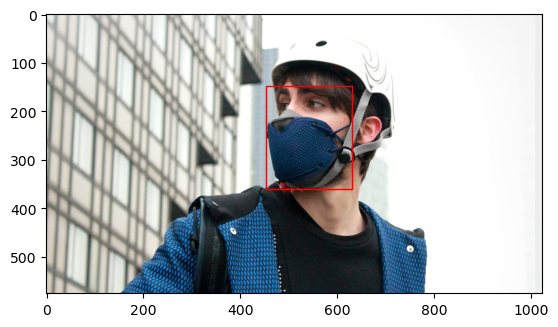

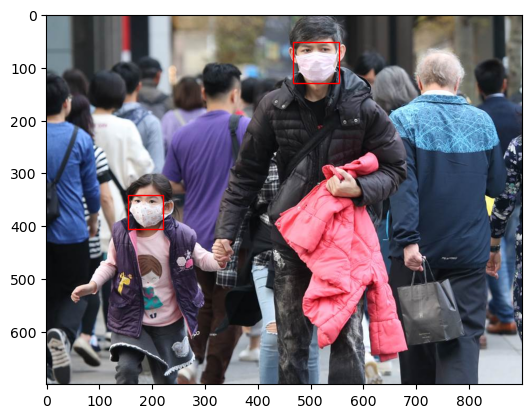

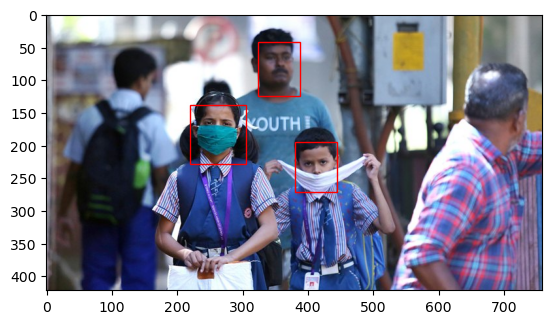

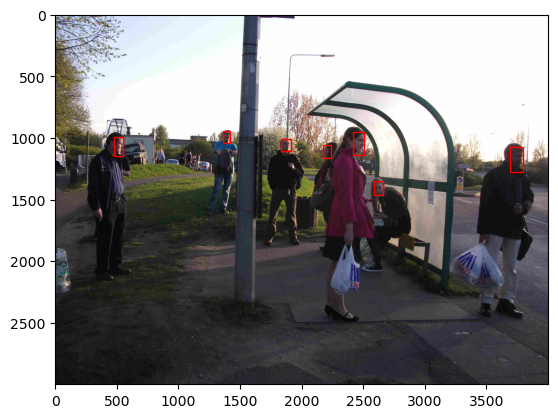

In [64]:
path = Path("datasets/train")
sample_images = list(path.joinpath("images").glob("*.jpg"))[:5]
sample_labels = [path.parents[1].joinpath("labels", path.stem + ".txt") for path in sample_images]

utils.display_images_with_bbox(sample_images, sample_labels)

# Resize Images

In [65]:
def resize_image_and_labels(
    image_dir, label_dir, output_image_dir, output_label_dir, new_size
):
    # Create output directories if they don't exist
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_label_dir, exist_ok=True)

    # Get list of images in image directory
    image_files = os.listdir(image_dir)

    for image_file in image_files:
        # Read image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)

        # Get original image dimensions
        original_height, original_width = image.shape[:2]

        # Resize image
        resized_image = cv2.resize(image, new_size)

        # Write resized image to output directory
        output_image_path = os.path.join(output_image_dir, image_file)
        cv2.imwrite(output_image_path, resized_image)

        # Read corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(label_dir, label_file)

        # Adjust bounding box coordinates in label file
        with open(label_path, "r") as f:
            lines = f.readlines()

        with open(os.path.join(output_label_dir, label_file), "w") as f:
            for line in lines:
                parts = line.strip().split(" ")
                class_id = parts[0]
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # Convert coordinates from relative to absolute
                x_center *= original_width
                y_center *= original_height
                width *= original_width
                height *= original_height

                # Resize coordinates
                x_center *= new_size[0] / original_width
                y_center *= new_size[1] / original_height
                width *= new_size[0] / original_width
                height *= new_size[1] / original_height

                # Convert coordinates back to relative
                x_center /= new_size[0]
                y_center /= new_size[1]
                width /= new_size[0]
                height /= new_size[1]

                # Write adjusted bounding box coordinates to output label file
                f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")


directories = {
    "train": [
        "datasets/train/images",
        "datasets/train/labels",
        "datasets/resized-train/images",
        "datasets/resized-train/labels",
    ],
    "val": [
        "datasets/valid/images",
        "datasets/valid/labels",
        "datasets/resized-valid/images",
        "datasets/resized-valid/labels",
    ],
    "test": [
        "datasets/test/images",
        "datasets/test/labels",
        "datasets/resized-test/images",
        "datasets/resized-test/labels",
    ],
}

for directory in directories.values():
    image_dir = directory[0]
    label_dir = directory[1]
    output_image_dir = directory[2]
    output_label_dir = directory[3]
    new_size = (320, 320)

    resize_image_and_labels(
        image_dir, label_dir, output_image_dir, output_label_dir, new_size
    )

# Display Images Again After Resizing

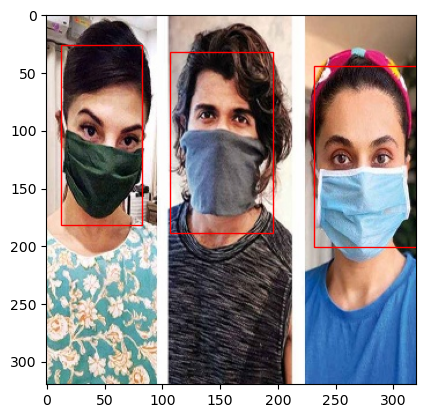

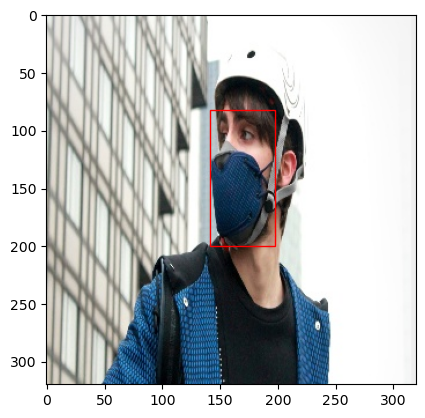

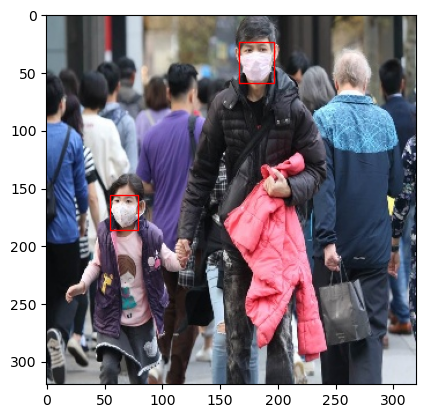

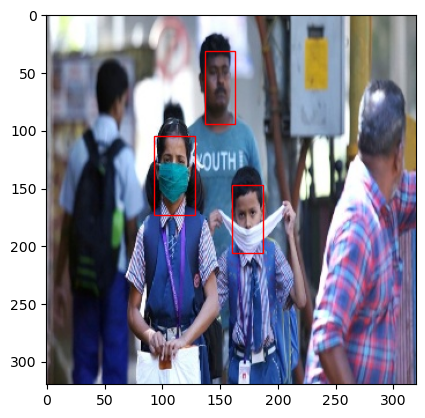

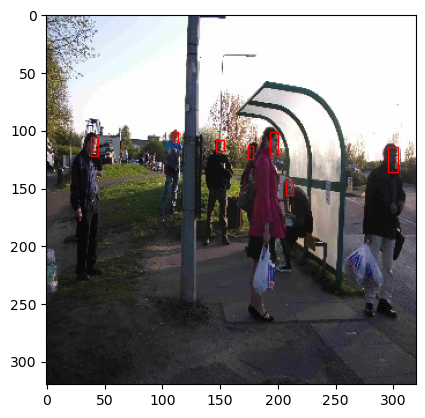

In [66]:
path = Path("datasets/resized-train")
sample_images = list(path.joinpath("images").glob("*.jpg"))[:5]
sample_labels = [path.parents[1].joinpath("labels", path.stem + ".txt") for path in sample_images]

utils.display_images_with_bbox(sample_images, sample_labels)

# Training

In [67]:
!yolo task=detect mode=train model=yolov8n.pt data=datasets/data.yaml epochs=10 imgsz=320

Ultralytics YOLOv8.2.27 🚀 Python-3.8.19 torch-2.0.0 CPU (AMD Ryzen 5 5500U with Radeon Graphics)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

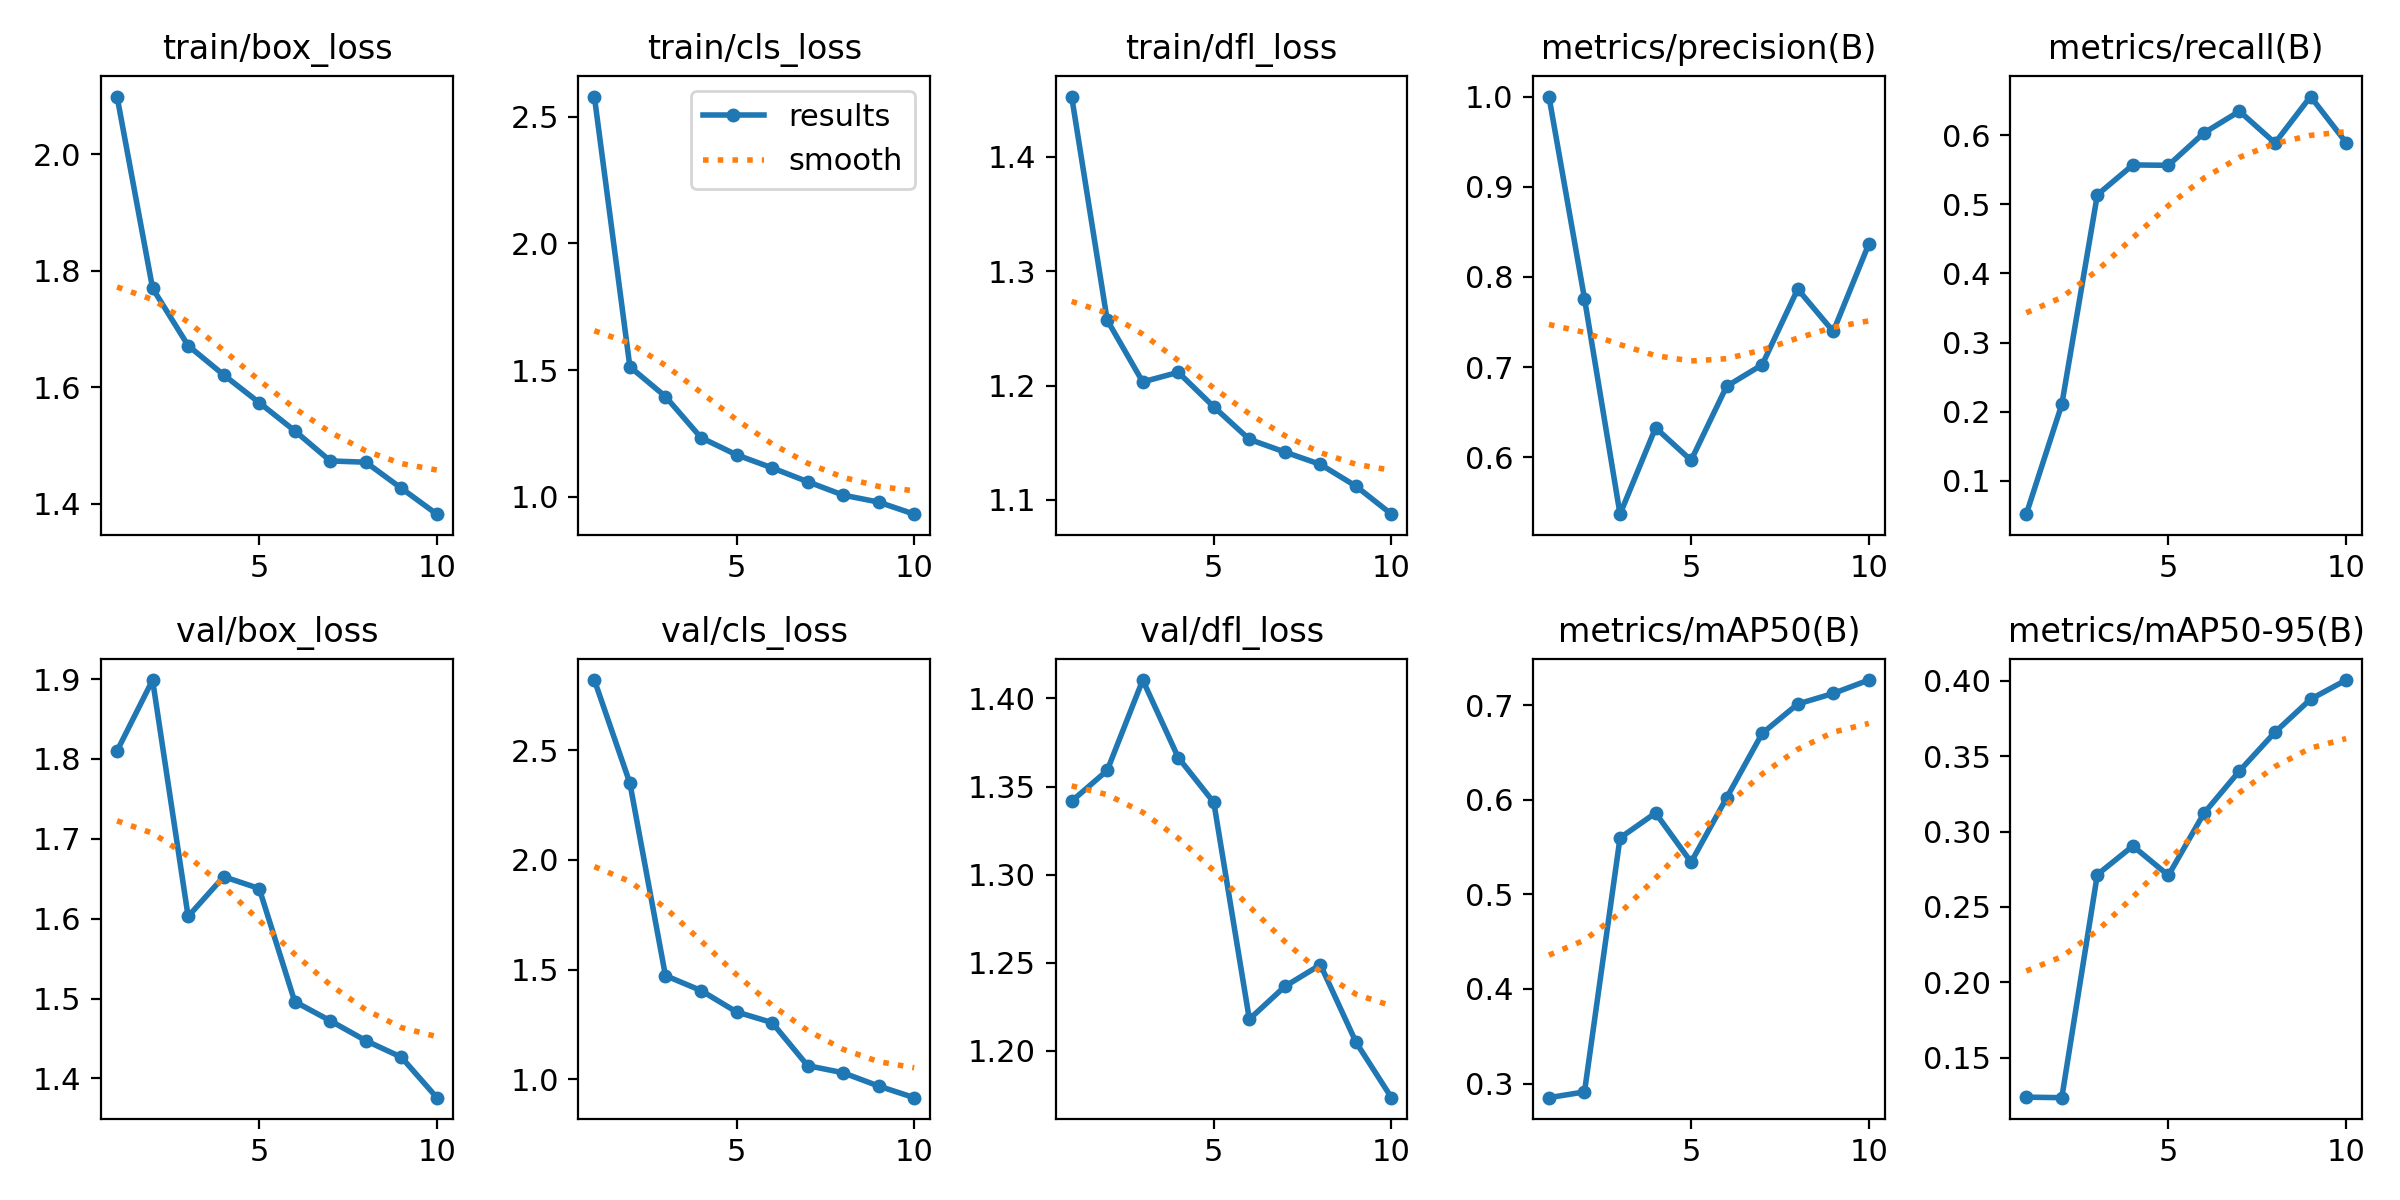

In [75]:
path = "runs/detect/train4/results.png"
Image(path)

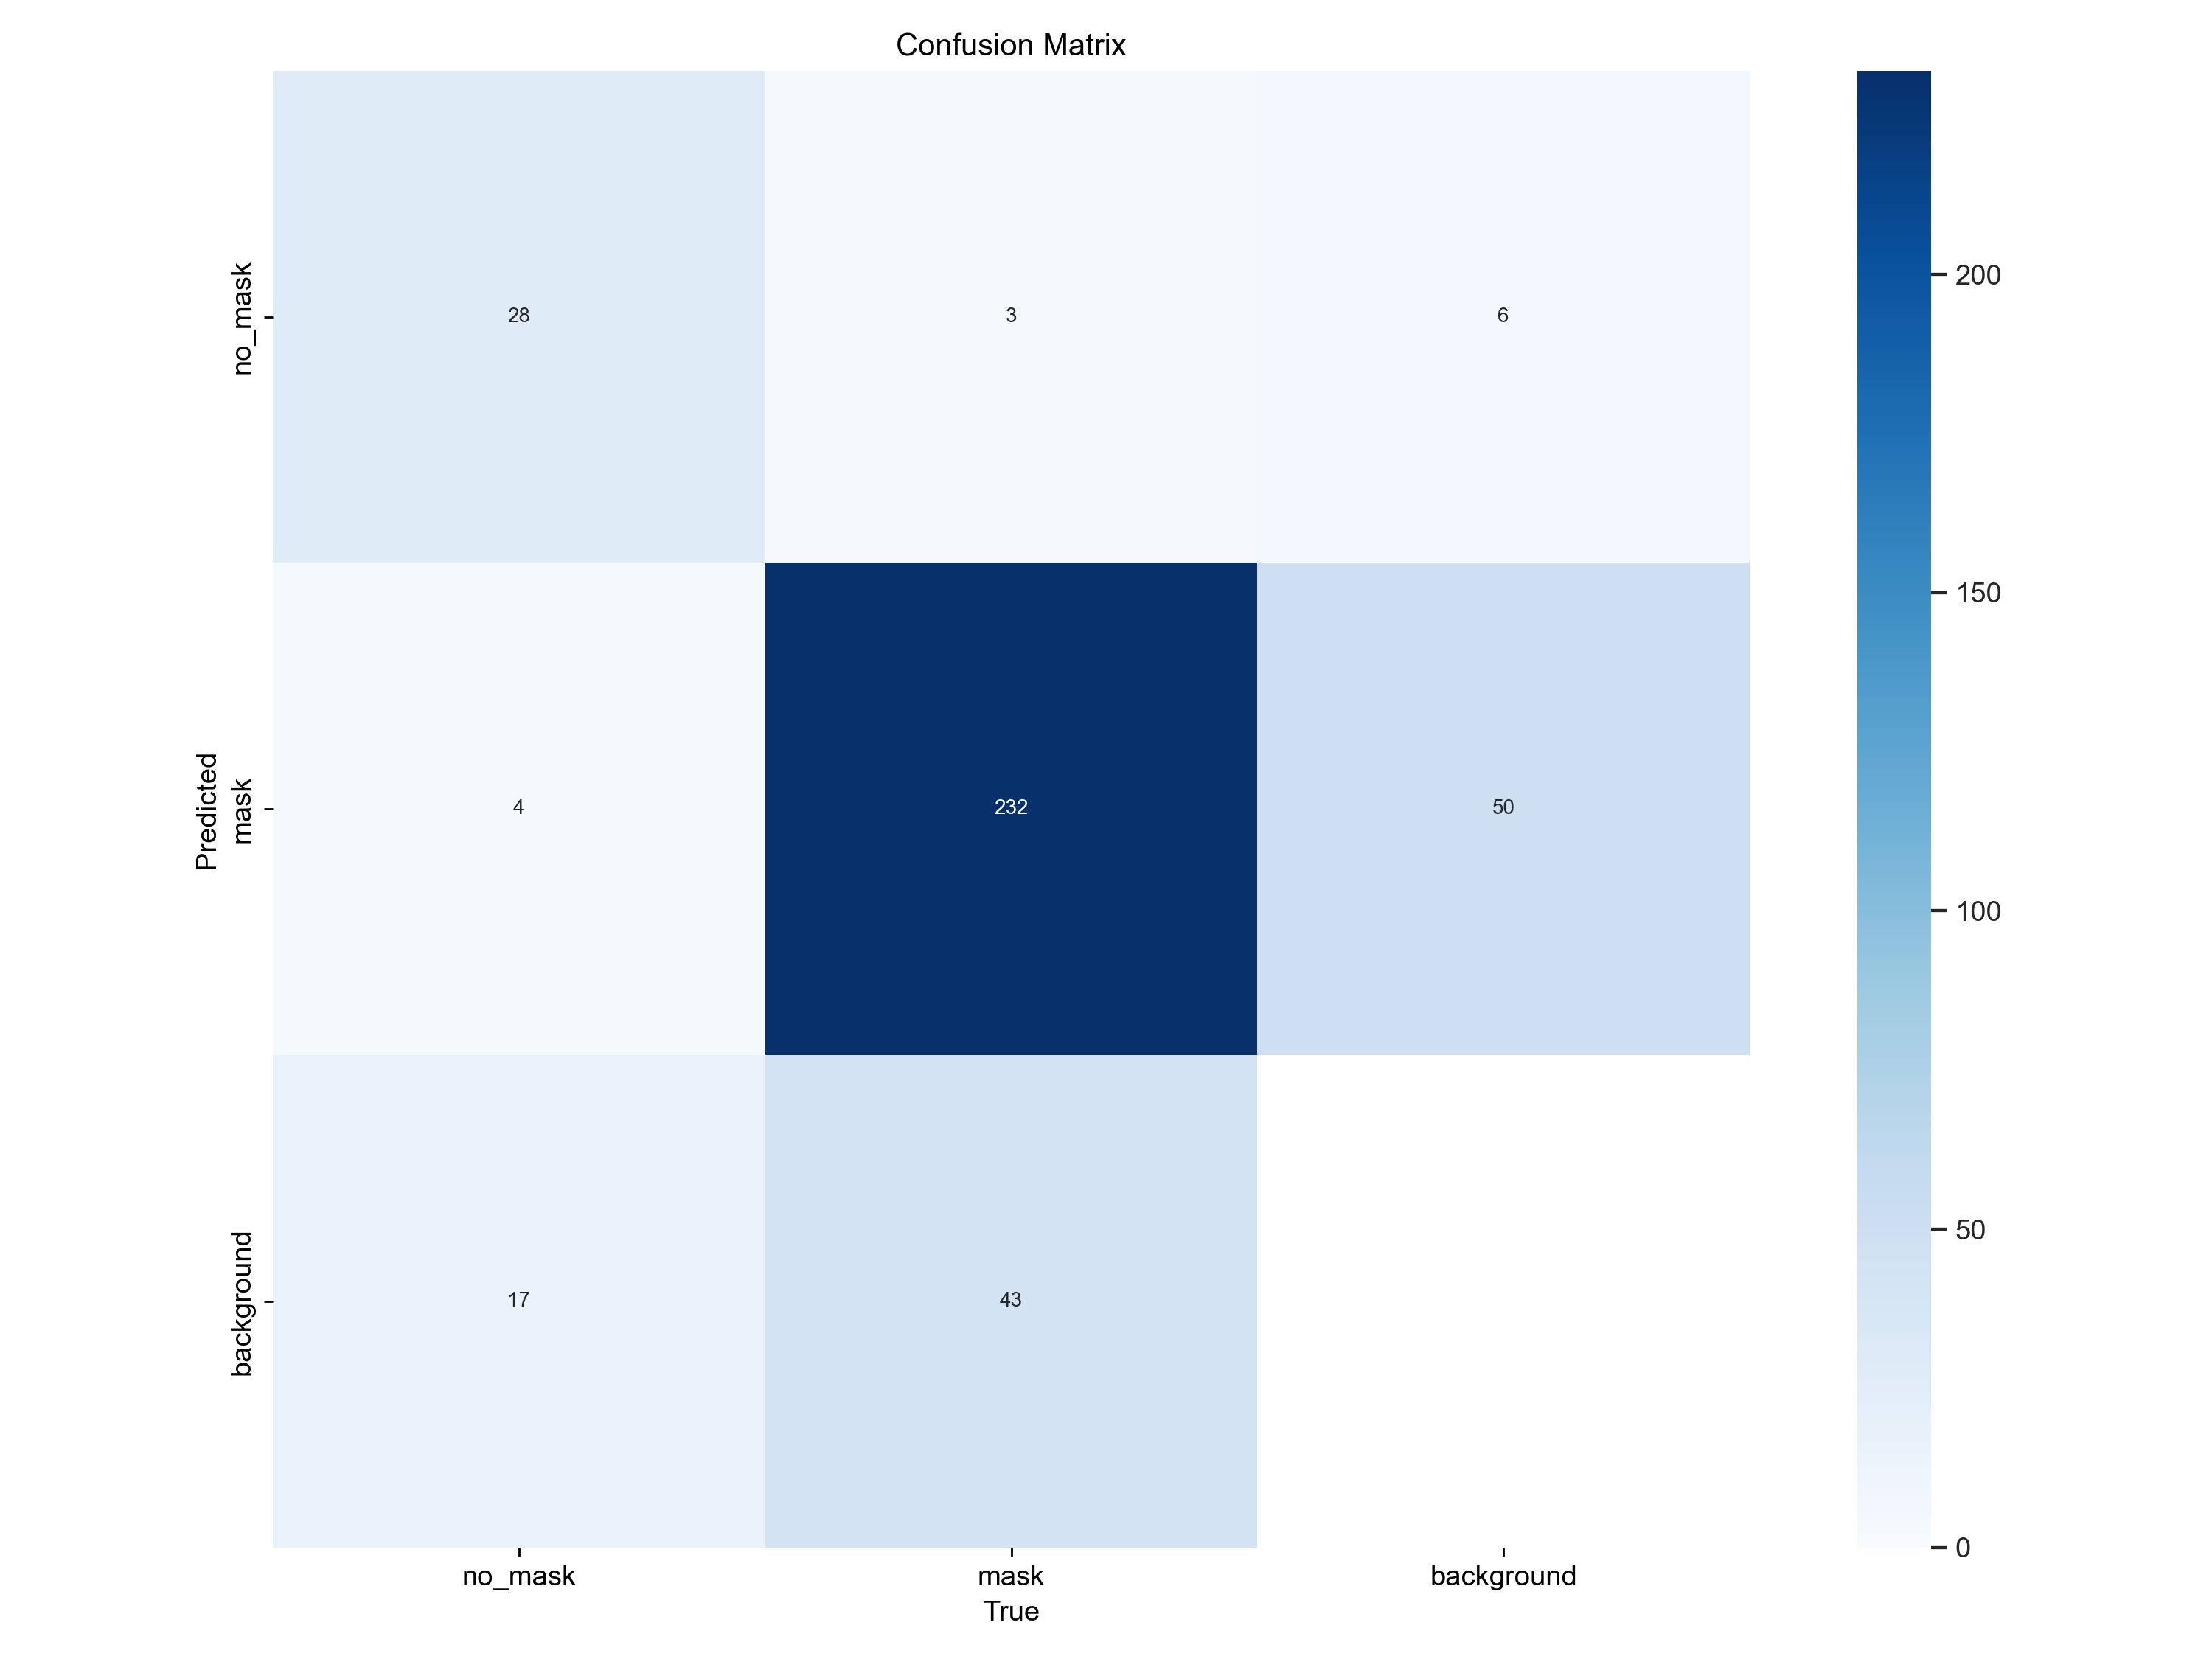

In [73]:
path = "runs/detect/train4/confusion_matrix.png"
Image(path)

# Validation

In [76]:
!yolo task=detect mode=val model=runs/detect/train4/weights/best.pt data=datasets/data.yaml

Ultralytics YOLOv8.2.27 🚀 Python-3.8.19 torch-2.0.0 CPU (AMD Ryzen 5 5500U with Radeon Graphics)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /home/anj/Documents/practice/finetune yolo/datasets/resized-valid/
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        100        327      0.835      0.589      0.726        0.4
               no_mask         27         49      0.768      0.408      0.589      0.263
                  mask         93        278      0.903      0.771      0.864      0.537
Speed: 2.1ms preprocess, 100.2ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


# Test


0: 320x320 4 no_masks, 74.4ms
1: 320x320 1 no_mask, 3 masks, 74.4ms
2: 320x320 1 no_mask, 18 masks, 74.4ms
3: 320x320 4 no_masks, 74.4ms
4: 320x320 1 no_mask, 5 masks, 74.4ms
5: 320x320 4 masks, 74.4ms
6: 320x320 2 no_masks, 2 masks, 74.4ms
7: 320x320 3 masks, 74.4ms
8: 320x320 6 masks, 74.4ms
9: 320x320 2 no_masks, 5 masks, 74.4ms
Speed: 1.6ms preprocess, 74.4ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)


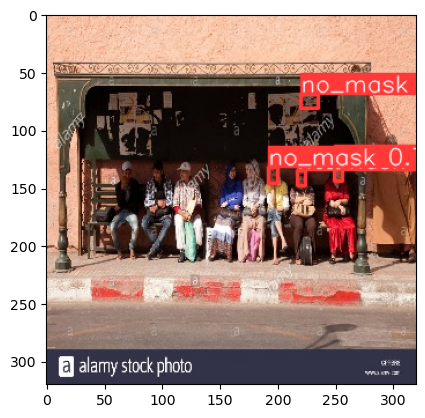

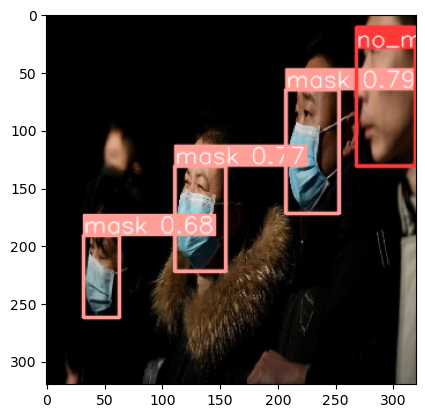

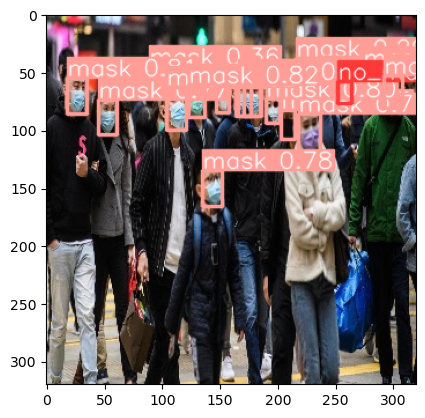

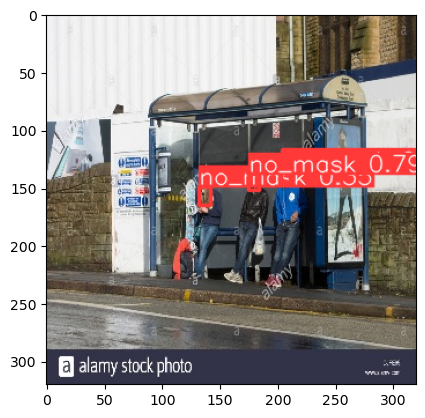

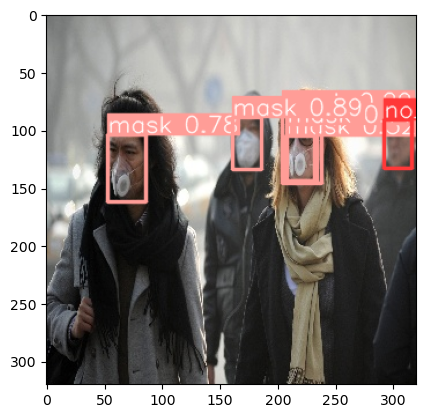

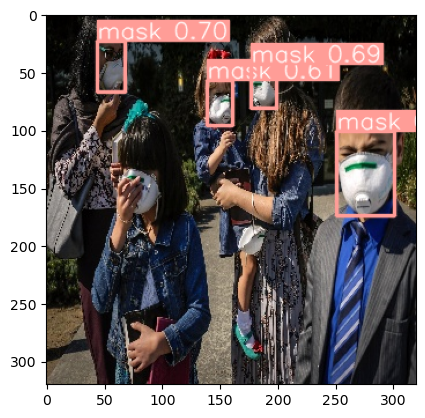

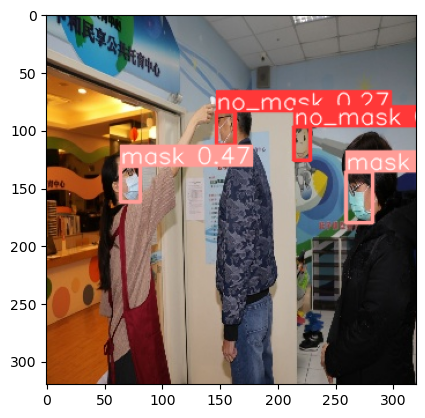

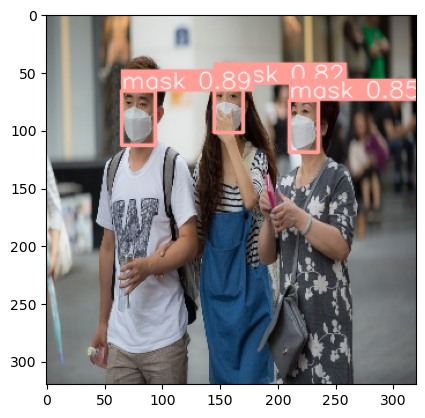

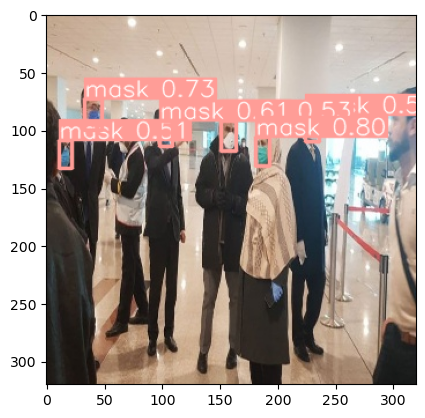

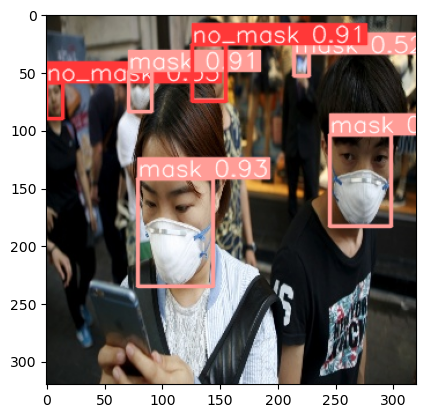

In [108]:
import matplotlib.pyplot as plt
import cv2


model = YOLO("runs/detect/train4/weights/best.pt")

# run batched inference on a list of images
path = Path("datasets/resized-test")
images = list(path.joinpath("images").glob("*.jpg"))
results = model([str(path) for path in images[:10]], stream=False)

for result in results:
    image = result.plot()  
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1)
    ax.imshow(rgb_image)